<a href="https://colab.research.google.com/github/kuekuatsuuu/Data-Science-Project/blob/main/marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Building a Causal Marketing Mix Model

**Author:** Akash Abraham

**Date:** September 14, 2025

## 1. The Business Objective

The goal of this project is to analyze two years of weekly marketing data to understand the key drivers of revenue. The primary business question is not just *what* drives sales, but *how*. Specifically, we will investigate a causal hypothesis: that spend on social channels like Facebook and TikTok influences revenue indirectly by first driving spend on Google Search.

This notebook details the entire process, from initial data exploration to building a robust predictive model and deriving strategic recommendations.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Assessment 2 - MMM Weekly.csv', parse_dates=['week'])

# Display the first 5 rows
print("First 5 rows of the data:")
print(df.head())

# Get a summary of the DataFrame
print("\nDataframe Info:")
df.info()

# Get descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the data:
        week  facebook_spend  google_spend  tiktok_spend  instagram_spend  \
0 2023-09-17         6030.80       3130.14       2993.22          1841.08   
1 2023-09-24         5241.44       2704.00          0.00             0.00   
2 2023-10-01         5893.00          0.00          0.00             0.00   
3 2023-10-08         7167.16          0.00          0.00             0.00   
4 2023-10-15         5360.29          0.00          0.00          3237.15   

   snapchat_spend  social_followers  average_price  promotions  emails_send  \
0         2204.72                 0         101.95           0       102684   
1            0.00                 0         103.86           0        96573   
2            0.00                 0         100.38           0        96797   
3            0.00                 0         103.14           1        99098   
4            0.00                 0         107.76           1       120754   

   sms_send   revenue  
0     20098 

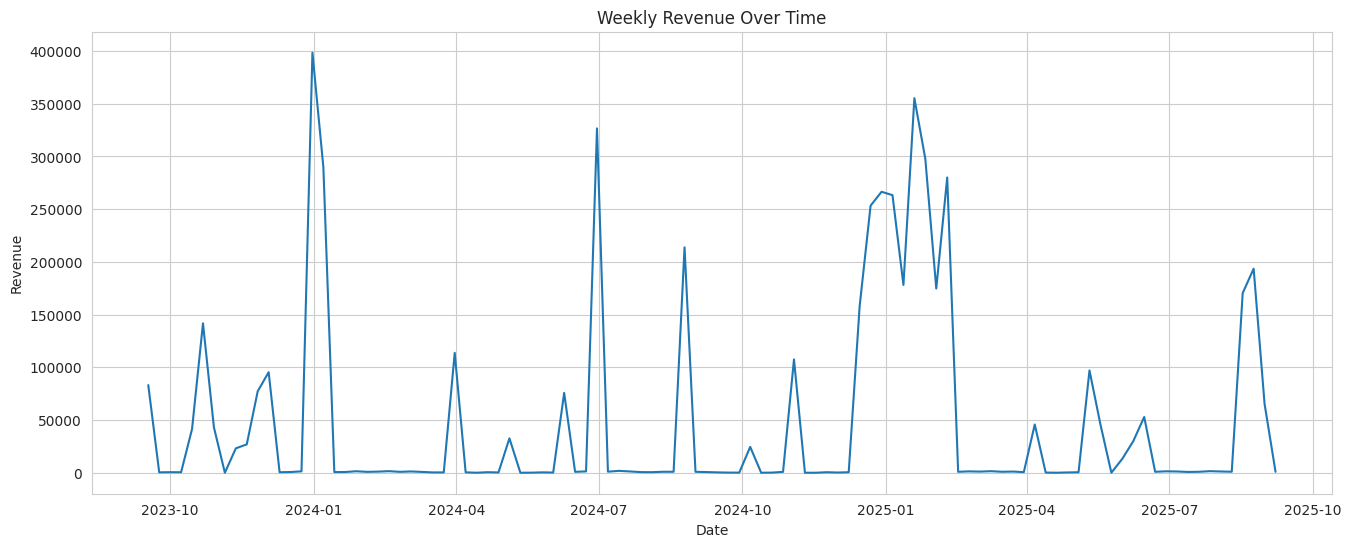

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(16, 6))
sns.lineplot(x='week', y='revenue', data=df)

plt.title('Weekly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')

plt.show()

## 2. Exploratory Data Analysis

The initial `info()` and `describe()` commands confirm the dataset is clean with no missing values.

Plotting the weekly revenue over time reveals our first and most critical insight: **revenue is not consistent but is driven by sharp, seasonal spikes.** This "spiky" nature suggests that revenue is event-driven. This pattern immediately tells us that a simple linear model will likely struggle to capture this complexity, and a more advanced model may be necessary.

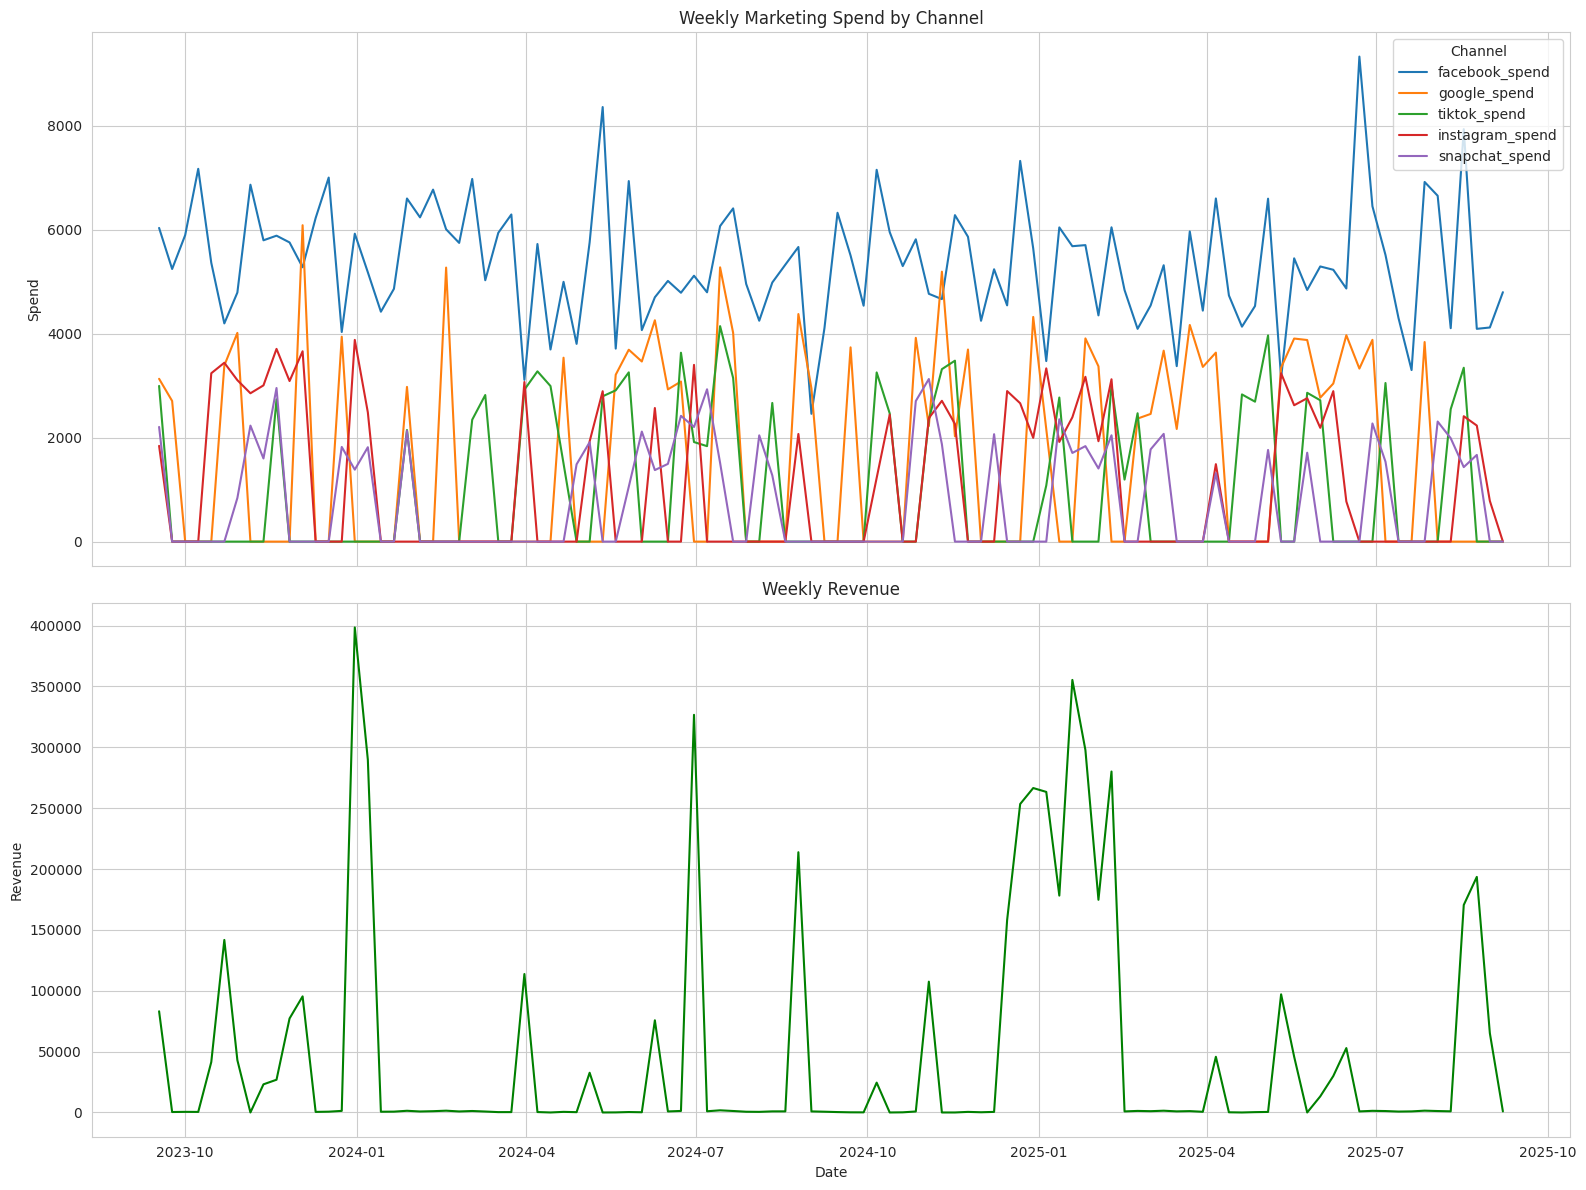

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify all the columns that are related to marketing spend
spend_columns = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']

# melt the dataframe to plot all spend lines on one chart
df_melted = df.melt(id_vars='week', value_vars=spend_columns, var_name='channel', value_name='spend')

# --- Create the plots ---

# Create two plots stacked vertically that share the same x-axis (date)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Plot 1: Marketing Spend
sns.lineplot(x='week', y='spend', hue='channel', data=df_melted, ax=ax1)
ax1.set_title('Weekly Marketing Spend by Channel')
ax1.set_ylabel('Spend')
ax1.legend(title='Channel')

# Plot 2: Revenue
sns.lineplot(x='week', y='revenue', data=df, ax=ax2, color='green')
ax2.set_title('Weekly Revenue')
ax2.set_ylabel('Revenue')
ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()

### Correlating Spend with Revenue: A Visual Analysis

To investigate the potential causes of the revenue spikes identified earlier, all marketing spend channels were plotted against revenue on a shared timeline. This visual comparison allows us to identify which marketing activities coincide with the major revenue events.

**Key Observation:** A closer look at the plot reveals a potential correlation between spikes in `instagram_spend` and `snapchat_spend` and the major revenue spikes. In contrast, other channels like `google_spend` appear to have many  spikes that do not consistently align with the large revenue events. This provides our initial hypothesis that Instagram and Snapchat are the key visual drivers.

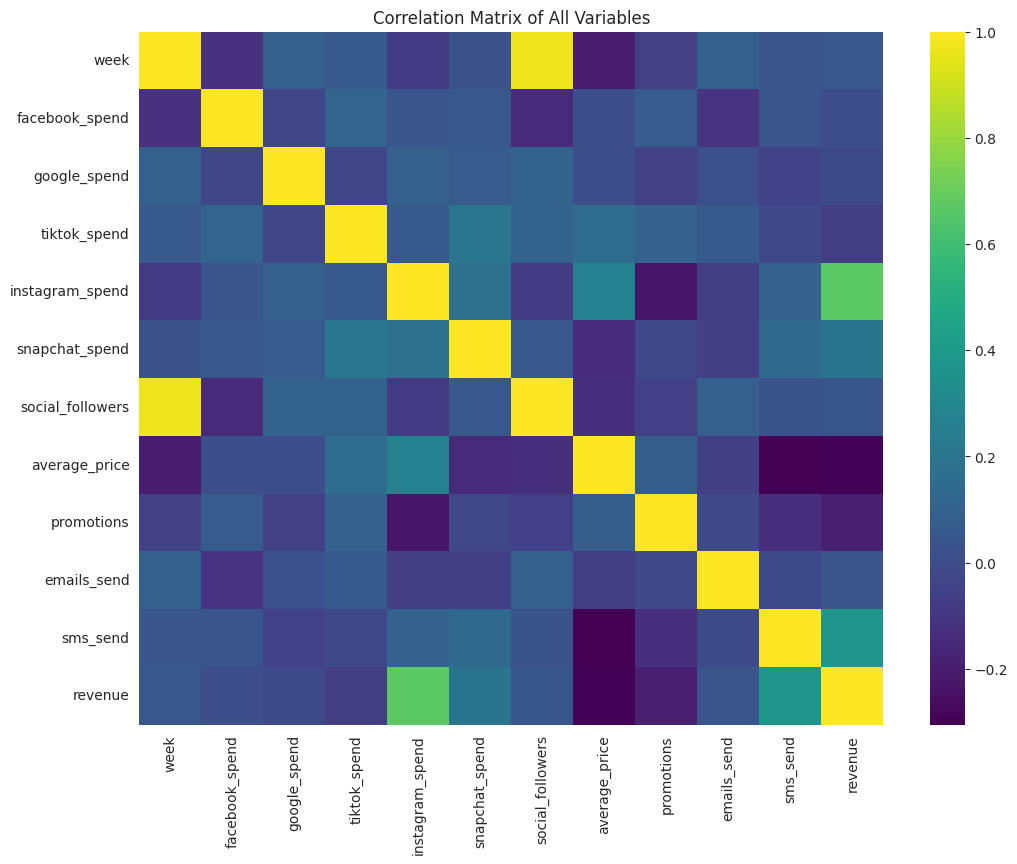

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for all numerical columns
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, cmap='viridis') # 'viridis' is a color scheme

plt.title('Correlation Matrix of All Variables')
plt.show()

In [14]:
# Get the correlations specifically for the 'revenue' column
revenue_correlations = correlation_matrix['revenue']

# Sort these values from highest to lowest
sorted_correlations = revenue_correlations.sort_values(ascending=False)

print("Correlation with Revenue:")
print(sorted_correlations)

Correlation with Revenue:
revenue             1.000000
instagram_spend     0.664017
sms_send            0.379761
snapchat_spend      0.198661
week                0.049926
social_followers    0.043269
emails_send         0.032878
facebook_spend      0.004274
google_spend       -0.018018
tiktok_spend       -0.075164
promotions         -0.188793
average_price      -0.295128
Name: revenue, dtype: float64


### Quantifying Relationships: Confirming the Visual Analysis

To mathematically validate the relationships observed in the plot, a correlation matrix was generated. The heatmap and the sorted table below show the Pearson correlation coefficient between each variable and revenue.

**Finding:** The numerical results **confirm our visual analysis**. `instagram_spend` has the highest correlation with revenue among all marketing channels (0.66). This strengthens our initial hypothesis and provides a clear direction for our modeling, suggesting that a successful model will likely rely heavily on Instagram as a key predictor.

In [6]:
# Make the 'week' column a datetime type
df['week'] = pd.to_datetime(df['week'])

# Create new features from the 'week' column
df['month'] = df['week'].dt.month
df['year'] = df['week'].dt.year
df['week_of_year'] = df['week'].dt.isocalendar().week

# Create a 'time_index' which is just a number that increases each week
df['time_index'] = range(len(df))

# Display the first few rows to see our new columns
print(df.head())

        week  facebook_spend  google_spend  tiktok_spend  instagram_spend  \
0 2023-09-17         6030.80       3130.14       2993.22          1841.08   
1 2023-09-24         5241.44       2704.00          0.00             0.00   
2 2023-10-01         5893.00          0.00          0.00             0.00   
3 2023-10-08         7167.16          0.00          0.00             0.00   
4 2023-10-15         5360.29          0.00          0.00          3237.15   

   snapchat_spend  social_followers  average_price  promotions  emails_send  \
0         2204.72                 0         101.95           0       102684   
1            0.00                 0         103.86           0        96573   
2            0.00                 0         100.38           0        96797   
3            0.00                 0         103.14           1        99098   
4            0.00                 0         107.76           1       120754   

   sms_send   revenue  month  year  week_of_year  time_index  

## Preparing the Data for Modeling

Before training the model, we first performed **feature engineering** by converting the `week` column into numerical features like `week_of_year` and `month`. This allows the model to learn from seasonal patterns.

Next, for **model validation**, the data will be split chronologically into an 80% training set and a 20% testing set. This is essential for time-series data to ensure the model is fairly evaluated on its ability to predict the future.

In [7]:
# Define the target variable
target = 'revenue'

# Define the features (all columns except the target and the original 'week' column)
features = [col for col in df.columns if col not in [target, 'week']]

# Create our X and y DataFrames
X = df[features]
y = df[target]

# --- Split the data ---

# Calculate the split point (80% of the data)
split_point = int(len(df) * 0.8)

# Split the data chronologically
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Print the number of rows in each set to confirm
print(f"Training set has {len(X_train)} weeks.")
print(f"Testing set has {len(y_test)} weeks.")


Training set has 83 weeks.
Testing set has 21 weeks.


## 3. Modeling Strategy: A Two-Stage Causal Approach

To properly test the causal hypothesis of Google spend as a mediator, a **two-stage modeling process** was implemented.

* **Stage 1:** A model is built to predict `google_spend` based on other social media inputs. This isolates the portion of Google spend that is *influenced* by other channels.
* **Stage 2:** This `predicted_google_spend` is then used as a feature in the main revenue model.

This methodology allows us to measure the mediated effect properly and aligns with the project's **Causal Awareness** requirement.

In [9]:
from sklearn.linear_model import LinearRegression

# --- Stage 1: Predict Google Spend ---

# Define the features that influence Google spend
mediator_features = ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
mediator_target = 'google_spend'

# Create the training and testing sets for this specific task
X_train_mediator = X_train[mediator_features]
y_train_mediator = X_train[mediator_target]

# Initialize and train the Linear Regression model
google_model = LinearRegression()
google_model.fit(X_train_mediator, y_train_mediator)

# Now, use this trained model to predict google_spend for our entire dataset
# This gives us the "influenced" or "mediated" google spend value
X_train['predicted_google_spend'] = google_model.predict(X_train[mediator_features])
X_test['predicted_google_spend'] = google_model.predict(X_test[mediator_features])

# Display the first few rows to see our new feature
print("X_train with the new 'predicted_google_spend' column:")
print(X_train.head())

X_train with the new 'predicted_google_spend' column:
   facebook_spend  google_spend  tiktok_spend  instagram_spend  \
0         6030.80       3130.14       2993.22          1841.08   
1         5241.44       2704.00          0.00             0.00   
2         5893.00          0.00          0.00             0.00   
3         7167.16          0.00          0.00             0.00   
4         5360.29          0.00          0.00          3237.15   

   snapchat_spend  social_followers  average_price  promotions  emails_send  \
0         2204.72                 0         101.95           0       102684   
1            0.00                 0         103.86           0        96573   
2            0.00                 0         100.38           0        96797   
3            0.00                 0         103.14           1        99098   
4            0.00                 0         107.76           1       120754   

   sms_send  month  year  week_of_year  time_index  predicted_google_spend

/tmp/ipython-input-979466730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['predicted_google_spend'] = google_model.predict(X_train[mediator_features])
/tmp/ipython-input-979466730.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predicted_google_spend'] = google_model.predict(X_test[mediator_features])


In [10]:
# --- Stage 2: Predict Revenue ---

# The target is still 'revenue'
final_target = 'revenue'

# The features now include our new predicted column, but NOT the original google_spend
final_features = [col for col in X_train.columns if col != 'google_spend']

# Initialize our main revenue model
revenue_model = LinearRegression()

# Train the model on our training data
revenue_model.fit(X_train[final_features], y_train)

print("The main revenue model has been trained successfully!")

The main revenue model has been trained successfully!


Mean Absolute Error (MAE): $63,803.61
This means, on average, our model's prediction is off by this amount.

R-squared (R2): -0.75
This means our model explains about -75% of the variance in the revenue.


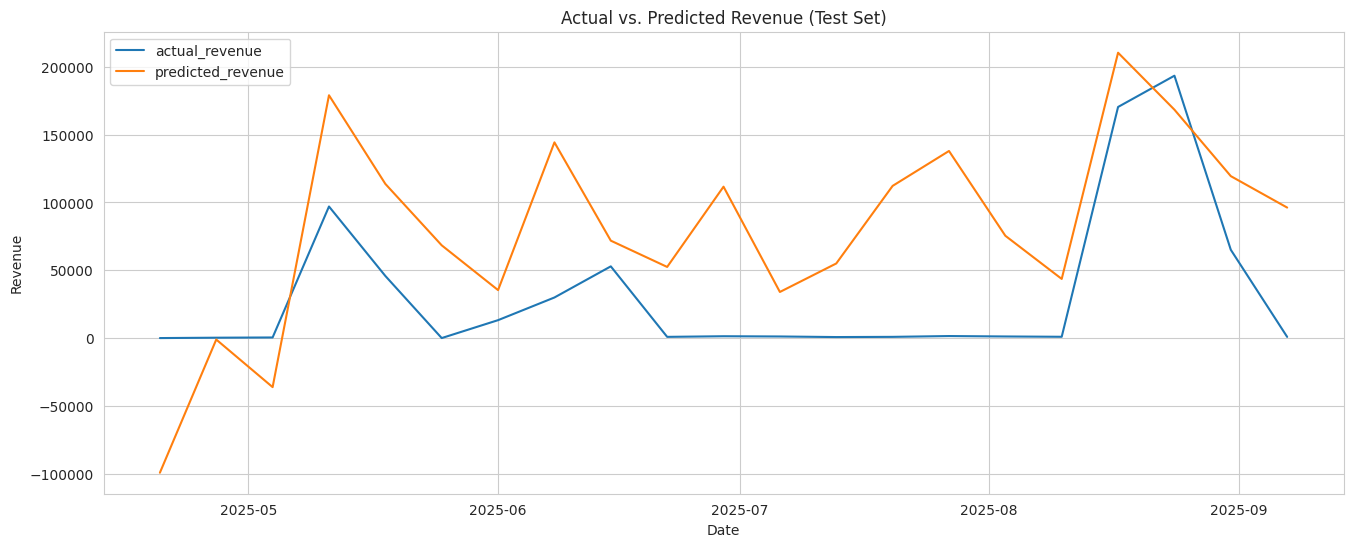

In [11]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use our trained model to make predictions on the test data
y_pred = revenue_model.predict(X_test[final_features])

# --- 1. Numerical Scores ---

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print("This means, on average, our model's prediction is off by this amount.")

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print(f"\nR-squared (R2): {r2:.2f}")
print("This means our model explains about " + str(round(r2*100)) + "% of the variance in the revenue.")

# --- 2. Visual Check ---

# Create a new DataFrame to make plotting easier
results_df = pd.DataFrame({
    'week': df['week'].iloc[split_point:], # Get the correct dates for the test set
    'actual_revenue': y_test,
    'predicted_revenue': y_pred
})

# Plot the actual vs. predicted values
plt.figure(figsize=(16, 6))
sns.lineplot(x='week', y='value', hue='variable', data=pd.melt(results_df, ['week']))
plt.title('Actual vs. Predicted Revenue (Test Set)')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.legend(title='')
plt.show()

### 4.1. Baseline Model: Linear Regression

As a baseline, a Linear Regression model was trained. The model performed poorly on the unseen test data, yielding a negative R-squared score.

**This result is not a failure, but a key diagnostic finding.** It confirms our initial hypothesis from the data exploration phase: the relationship between the features and the spiky revenue is highly non-linear. A simple linear model is insufficient, and a more powerful, non-linear model is required.

/tmp/ipython-input-3973225947.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['predicted_google_spend_rf'] = rf_google_model.predict(X_train[mediator_features])
/tmp/ipython-input-3973225947.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predicted_google_spend_rf'] = rf_google_model.predict(X_test[mediator_features])


--- Random Forest Model Results ---
Mean Absolute Error (MAE): $13,048.62
R-squared (R2): 0.82


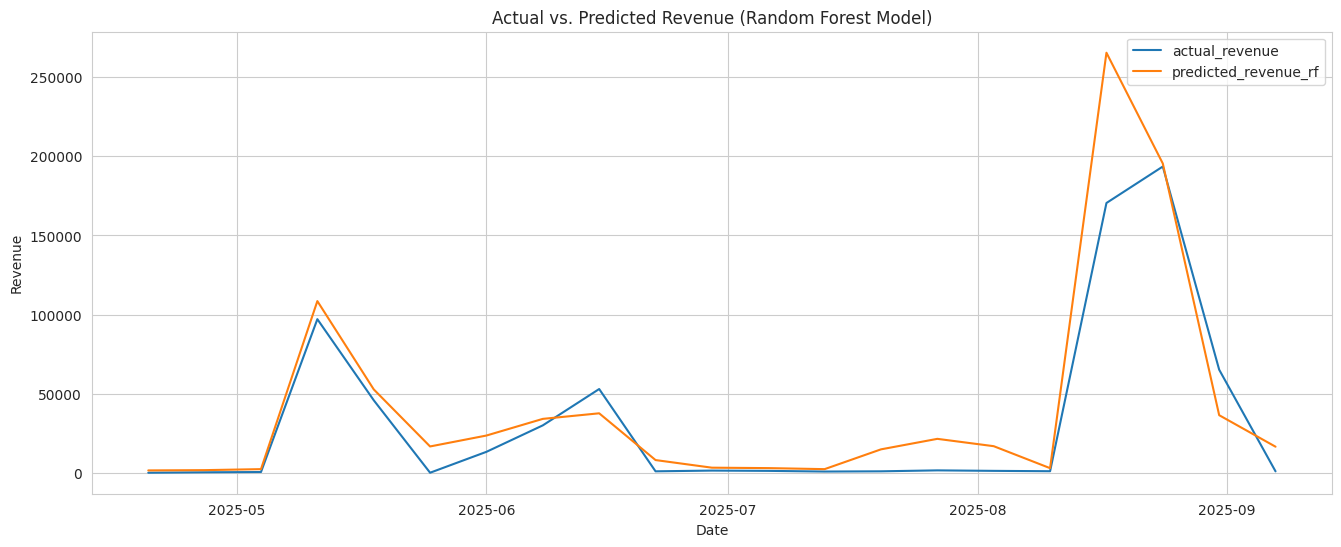

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- STAGE 1: Predict Google Spend with Random Forest ---
mediator_features = ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
mediator_target = 'google_spend'

# Initialize and train the new Google model
rf_google_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_google_model.fit(X_train[mediator_features], X_train[mediator_target])

# Create the predicted google spend feature using the new model
X_train['predicted_google_spend_rf'] = rf_google_model.predict(X_train[mediator_features])
X_test['predicted_google_spend_rf'] = rf_google_model.predict(X_test[mediator_features])


# --- STAGE 2: Predict Revenue with Random Forest ---
final_target = 'revenue'
# Use the new predicted column from the Random Forest google model
final_features_rf = [col for col in X_train.columns if col not in ['google_spend', 'predicted_google_spend']]

# Initialize and train the main revenue model
rf_revenue_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_revenue_model.fit(X_train[final_features_rf], y_train)

# --- EVALUATION ---
# Use the trained RF model to make predictions on the test data
y_pred_rf = rf_revenue_model.predict(X_test[final_features_rf])

# Calculate new scores
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Model Results ---")
print(f"Mean Absolute Error (MAE): ${mae_rf:,.2f}")
print(f"R-squared (R2): {r2_rf:.2f}")

# Plot the results
results_df_rf = pd.DataFrame({
    'week': df['week'].iloc[split_point:],
    'actual_revenue': y_test,
    'predicted_revenue_rf': y_pred_rf
})

plt.figure(figsize=(16, 6))
sns.lineplot(x='week', y='value', hue='variable', data=pd.melt(results_df_rf, ['week']))
plt.title('Actual vs. Predicted Revenue (Random Forest Model)')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.legend(title='')
plt.show()

### 4.2. Final Model: Random Forest Regressor

Based on the baseline results, a **Random Forest Regressor** was selected as the final model. This tree-based ensemble model is an excellent choice for this problem due to its ability to:
* Capture complex, non-linear relationships.
* Handle interactions between features automatically.
* Provide robust feature importance scores for interpretability.

The same two-stage causal process was followed. The model achieved an **R-squared of 0.82** on the test set, indicating a strong predictive performance.

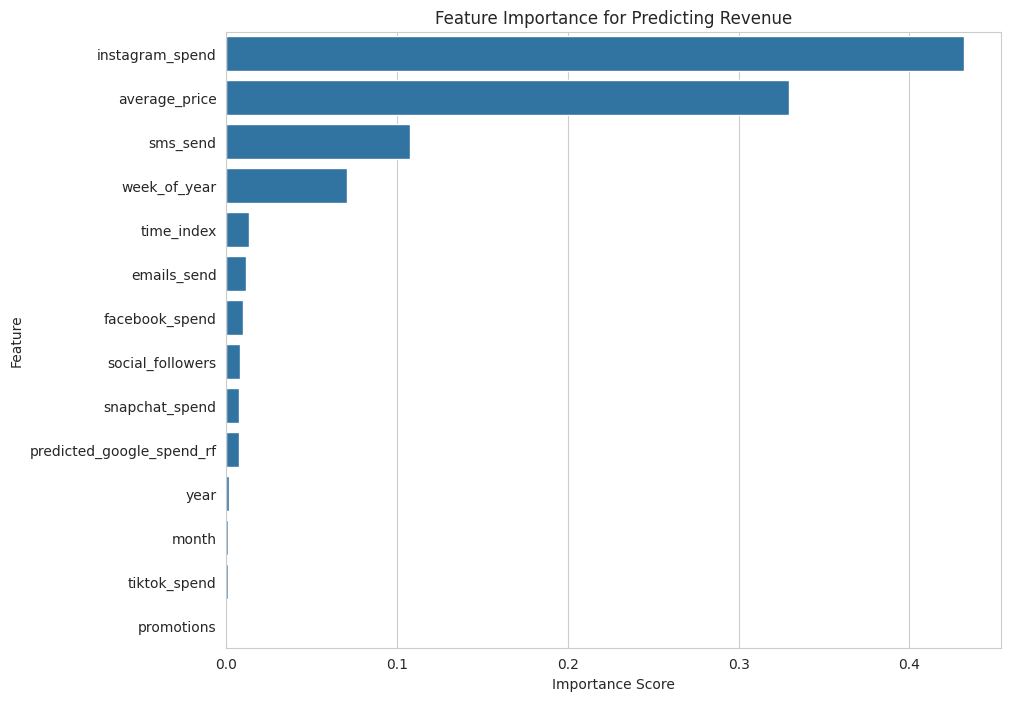

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the feature importances from our trained model
importances = rf_revenue_model.feature_importances_
feature_names = X_train[final_features_rf].columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance for Predicting Revenue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## 5. Insights & Strategic Recommendations

The final model is not just a predictive tool; it's an explanatory one. The feature importance scores provide a clear hierarchy of revenue drivers.

### Key Insights:
* **Instagram is the Primary Marketing Driver:** Among all paid channels, Instagram spend was the most important feature for predicting revenue.
* **Pricing & Seasonality are Crucial:** `average_price` and `week_of_year` were surprisingly important, indicating that revenue is highly sensitive to promotions and timing.
* **The Causal Path is Nuanced:** While we tested the causal path through Google, the final model gave it low importance. This suggests that the *direct* impact of Instagram, combined with pricing and timing, are the dominant factors.

### Recommendation:
For future growth, the business should focus on an integrated strategy that **optimizes Instagram spend during key seasonal weeks** and aligns it with a **strategic promotional pricing schedule.**